There is a low level engine for differentiation - torch.autograd
With writing (grad, ) = torch.autograd.grad(output, inputs, retain_graph=None, create_graph=False)
output should be tensor with rank 0 (scalar),
grad = $\frac{\partial (output)}{\partial (input)}$
* Using create_graph=True makes computational graph with grad, so grad.requires_grad = True! For example, one can make .sum of these grad and use it as regularization while studying
* retain_graph=True means that after every calculation torch does not recreate graph, like it is realized in TensorFlow

And one more hint(obvious) - to detach tensor from computational graph one can use .detach(), it is out place operation

In [1]:
import torch
from torch import autograd
from torch.nn import functional as F
from PIL import Image as pil
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def load_image(path) -> torch.Tensor:
    """
    Loads img from path, make required transforms and returns TENSOR
    """
    assert os.path.exists(path)
    pil_img = pil.open(path)
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                torchvision.transforms.Resize((224, 224)),
                                                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    return transform(pil_img)[None, :, :, :]

In [4]:
def compute_saliency_map(model, class_id, image_tensor):
    """
    Calculates gradient of predicted class over image and then applies abs:
    
    |d(model(IMAGE) [chosen class]) / d(IMAGE)|
    
    This gradient shows how strong predicted probability depends on each pixel of Image, so
    it makes 'heatmap' of chosen class on the Image
    """
    image_tensor.requires_grad_(True)
    y = model(image_tensor)[:, class_id]
    (grad, ) = autograd.grad(y, image_tensor)
    
    saliency_map = torch.abs(grad.cpu().detach())
    
    return saliency_map

In [5]:
def tensor_to_image(image_tensor):
    """
    Converts tensor image to numpy image
    """
    image_tensor = image_tensor[0]
    image_tensor = image_tensor.permute((1, 2, 0))
    image_numpy = image_tensor.detach().cpu().numpy()
    
    return image_numpy

In [6]:
def renormalize_image(x):
    """
    Converts image values of image to [0, 255] with type np.uint8
    """
    x = (x - np.min(x))
    x = x / np.max(x) * 255
    
    return x.astype(np.uint8)

In [14]:
model = torchvision.models.vgg16(pretrained=True).to(device).requires_grad_(False)
model

C:\Users\Никита\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Никита\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
img_tensor = load_image('1200px-Roosterhawaii.jpg').cuda()

In [16]:
mp = compute_saliency_map(model, 7, img_tensor)

In [17]:
saliency_map = tensor_to_image(mp).max(-1)
image = renormalize_image(tensor_to_image(img_tensor))

In [18]:
from scipy import ndimage
heatmap = ndimage.gaussian_filter(saliency_map[:,:,None], 8, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

In [19]:
heatmap = renormalize_image(heatmap)/255

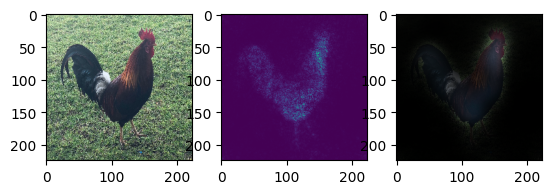

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(saliency_map)
ax = fig.add_subplot(1, 3, 3)
ax.imshow((image*heatmap).astype(np.uint8))